# Notebook to open and view detections on audio:

## 1) Figuring out our imports:

### a) Below are the imports pertaining to accessing data and metadata

In [1]:
from pathlib import Path
import glob
import exiftool
import soundfile as sf

### b) Below are the imports pertaining to data manipulation

In [2]:
import numpy as np
import pandas as pd
import dask.dataframe as dd

### c) Below are the imports pertaining to data visualization

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import colors
import datetime as dt

### d) Below are the imports pertaining to the use of the MSDS pipeline

In [4]:
import sys

# append the path of the
# parent directory
sys.path.append('..')
sys.path.append('../src/')
sys.path.append('../src/models/bat_call_detector/batdetect2/')

import src.batdt2_pipeline as batdetect2_pipeline
import src.file_dealer as file_dealer
from cfg import get_config

In [5]:
def plot_audio_seg(audio_features, spec_features):
    audio_seg = audio_features['audio_seg']
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    vmin = spec_features['vmin']
    cmap = spec_features['cmap']
    nfft = spec_features['NFFT']

    plt.figure(figsize=(15, 5))
    plt.rcParams.update({'font.size': 24})
    plt.title(f"Spectrogram of file: {audio_features['file_path'].name}")
    plt.specgram(audio_seg, NFFT=nfft, cmap=cmap, vmin=vmin)
    plt.yticks(ticks=np.linspace(0, 1, 6), labels=np.linspace(0, fs/2000, 6).astype('int'))
    plt.xticks(ticks=np.linspace(0, duration*(fs/2), 11), labels=np.round(np.linspace(start, start+duration, 11, dtype='float'), 2))
    plt.ylabel("Frequency (kHz)")
    plt.xlabel("Time (s)")
    plt.show()


def plot_dets_over_audio(audio_features, spec_features, plot_dets):
    audio_seg = audio_features['audio_seg']
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    vmin = spec_features['vmin']
    cmap = spec_features['cmap']
    nfft = spec_features['NFFT']

    plt.figure(figsize=(15, 5))
    plt.rcParams.update({'font.size': 24})
    plt.title(f"BD2 detections on {audio_features['file_path'].name}")
    plt.specgram(audio_seg, NFFT=nfft, cmap=cmap, vmin=vmin)

    ax = plt.gca()
    for i, row in plot_dets.iterrows():
        rect = patches.Rectangle(((row['start_time'] - start)*(fs/2), row['low_freq']/(fs/2)), 
                        (row['end_time'] - row['start_time'])*(fs/2), (row['high_freq'] - row['low_freq'])/(fs/2), 
                        linewidth=2, edgecolor='yellow', facecolor='none', alpha=0.8)
        ax.add_patch(rect)

    plt.yticks(ticks=np.linspace(0, 1, 6), labels=np.linspace(0, fs/2000, 6).astype('int'))
    plt.xticks(ticks=np.linspace(0, duration*(fs/2), 11), labels=np.round(np.linspace(start, start+duration, 11, dtype='float'), 2))
    plt.ylabel("Frequency (kHz)")
    plt.xlabel("Time (s)")
    plt.show()

In [6]:
input_files = sorted(glob.glob('../../Documents/recover-20230809/UBNA_015/*.WAV', recursive=True))
plot_file = input_files[16]
file_dt = dt.datetime.strptime(Path(plot_file).name, "%Y%m%d_%H%M%S.WAV")

batdetect2_predictions = pd.read_csv('../output_dir/recover-20230809/E18 Bridge/bd2__recover-20230809_UBNA_015.csv')
file_cond = pd.to_datetime(batdetect2_predictions['input_file'], format="%Y%m%d_%H%M%S", exact=False) == dt.datetime.strptime(Path(plot_file).name, "%Y%m%d_%H%M%S.WAV")
file_dets = batdetect2_predictions.loc[file_cond]

audio_file = sf.SoundFile(plot_file)
fs = audio_file.samplerate
start = 485
duration = 10
audio_file.seek(int(fs*start))
audio_seg = audio_file.read(int(fs*duration))
vmin = 20*np.log10(np.max(audio_seg)) - 45 # hide anything below -rm_dB dB

audio_features = dict()
audio_features['file_path'] = Path(plot_file)
audio_features['audio_seg'] = audio_seg
audio_features['sample_rate'] = fs
audio_features['start'] = start
audio_features['duration'] = duration

spec_features = dict()
spec_features['NFFT'] = 1024
spec_features['cmap'] = 'jet'
spec_features['vmin'] = vmin

plot_audio_seg(audio_features, spec_features)

window_cond = np.logical_and(file_dets['start_time'] > start, file_dets['end_time'] < (start+duration))
plot_dets = file_dets.loc[window_cond]
plot_dets_over_audio(audio_features, spec_features, plot_dets)

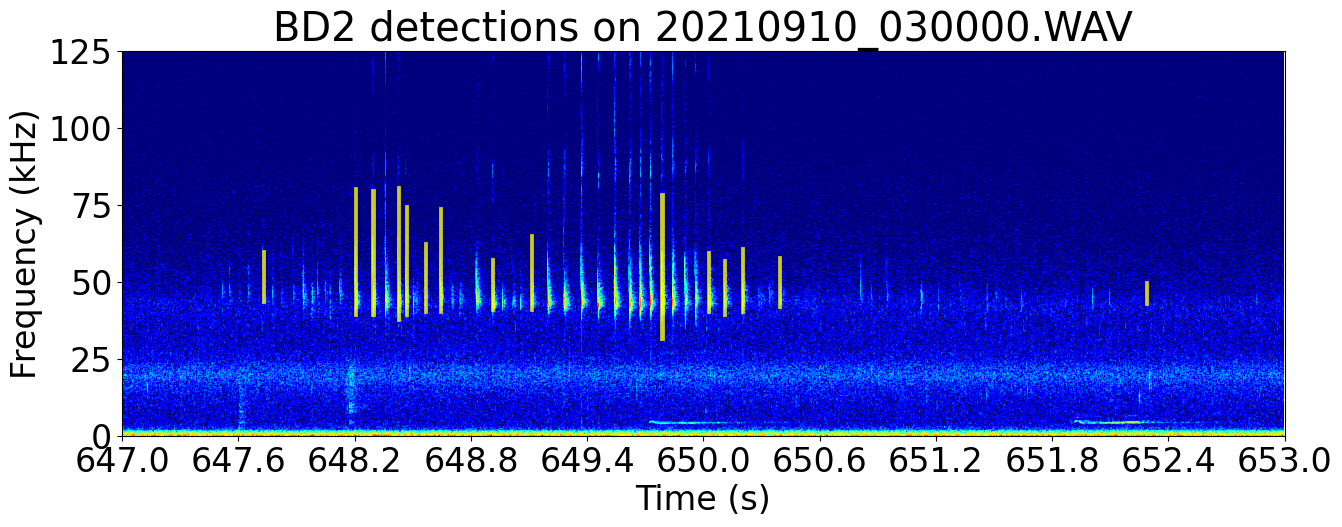

Generating detections for 20210910_030000_clipped647to653.WAV


100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


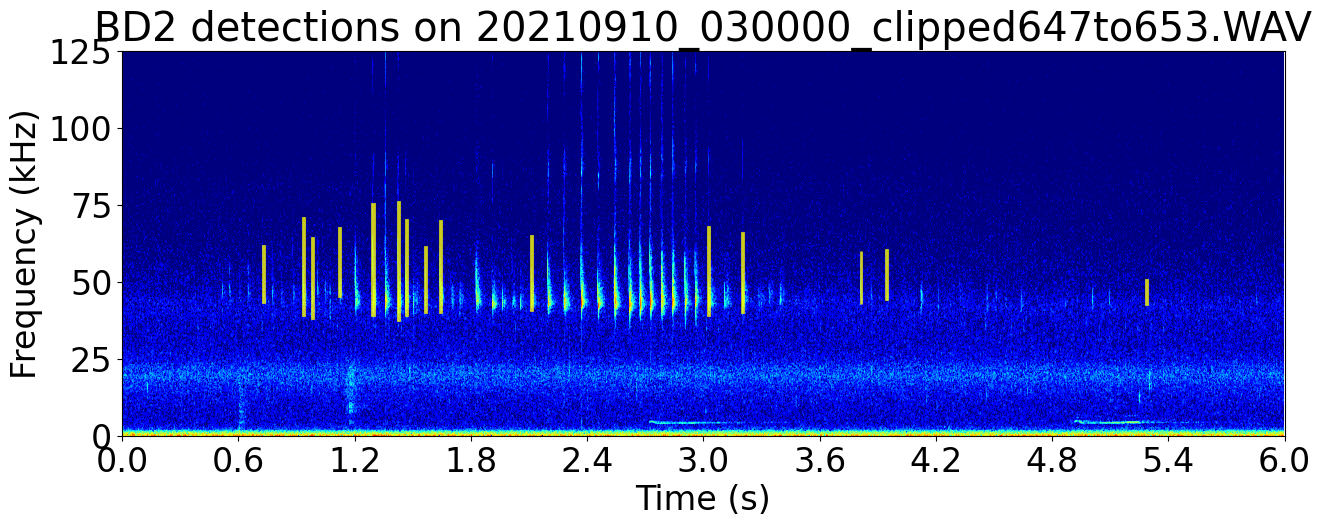

In [7]:
input_file = Path('../../Documents/Research/Lab_related/example/original_recording/recover-20210912_unit2/UBNA_002/20210910_030000.WAV')

cfg = get_config()
cfg['input_audio'] = Path(input_file)
cfg['tmp_dir'] = Path('../output')
cfg['output_dir'] = Path('../output_dir')
cfg['run_model'] = True
cfg['should_csv'] = True
cfg['save'] = True

filename = input_file.name.split('.')[0]
original_file_dets = pd.read_csv(f'../output_dir/batdetect2_pipeline_{filename}.csv')

audio_file = sf.SoundFile(input_file)
fs = audio_file.samplerate
start = 647
duration = 6
end = int(start+duration)
audio_file.seek(int(fs*start))
audio_seg = audio_file.read(int(fs*duration))
vmin = 20*np.log10(np.max(audio_seg)) - 50 # hide anything below -rm_dB dB
write_file = f'../../Downloads/{filename}_clipped{start}to{end}.WAV'

audio_features = dict()
audio_features['file_path'] = input_file
audio_features['audio_seg'] = audio_seg
audio_features['sample_rate'] = fs
audio_features['start'] = start
audio_features['duration'] = duration

spec_features = dict()
spec_features['NFFT'] = 1024
spec_features['cmap'] = 'jet'
spec_features['vmin'] = vmin

window_cond = np.logical_and(original_file_dets['start_time'] > start, original_file_dets['end_time'] < (start+duration))
original_plot_dets = original_file_dets.loc[window_cond]
plot_dets_over_audio(audio_features, spec_features, original_plot_dets)
sf.write(write_file, audio_seg, fs)

input_file = Path(write_file)

cfg = get_config()
cfg['input_audio'] = input_file
cfg['tmp_dir'] = Path('../output')
cfg['output_dir'] = Path('../output_dir')
cfg['run_model'] = True
cfg['should_csv'] = True
cfg['save'] = False

clipped_file_dets = batdetect2_pipeline.run_pipeline_on_file(input_file, cfg)

audio_file = sf.SoundFile(input_file)
fs = audio_file.samplerate
start = 0
audio_seg = audio_file.read()

audio_features = dict()
audio_features['file_path'] = input_file
audio_features['audio_seg'] = audio_seg
audio_features['sample_rate'] = fs
audio_features['start'] = start
audio_features['duration'] = duration

spec_features = dict()
spec_features['NFFT'] = 1024
spec_features['cmap'] = 'jet'
spec_features['vmin'] = vmin

window_cond = np.logical_and(clipped_file_dets['start_time'] > start, clipped_file_dets['end_time'] < (start+duration))
clipped_plot_dets = clipped_file_dets.loc[window_cond]
plot_dets_over_audio(audio_features, spec_features, clipped_plot_dets)

clipped_plot_dets['start_time'] = 646+clipped_plot_dets['start_time']
clipped_plot_dets['end_time'] = 646+clipped_plot_dets['end_time']

In [8]:
np.array_equal(original_plot_dets['start_time'].values, clipped_plot_dets['start_time'].values)

False